# Preprocessing Dataset and Generating Images:

## Introduction:
This notebook shows an overview of the steps taken for obtaining the OHLC datasets and creating training images. For this demo, I'll be using Apple's stock from $1993$ - $2019$. The functions that are showcased here were slightly modified in the `get_data.py` and `get_images.py` modules to handle multiple datasets and images. 

## Import Packages:
The packages below are used to compile this notebook correctly.

In [1]:
## Import necessary packages.
import yfinance as yf
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Acquire and Adjust OHLC Prices:
After obtaining a stock using `yfinance`, I "[replaced] prices by CRSP adjusted returns to translate the opening, closing, high, and low prices into relative scales that abstract from price effects of stock splits and dividend issuance."

From Yahoo Finance, it shows that the "Adjusted Closed Price" was calculated by multiplying the original "Closed Price" by the Split and Dividend multiplier. Since these features are constant for that certain day, we can call their combination the "Adjustment Factor".



\begin{equation*}
\text{Adjusted Closed Price} = \text{Adjustment Factor} \times \text{Closed Price}
\end{equation*}



\begin{equation*}
\text{Adjustment Factor} = \frac{\text{Adjusted Closed Price}}{\text{Closed Price}}
\end{equation*}



I then multiplied the "Adjustment Factor" to all the Open, High, and Low prices to adjust all the factors in the OHLC chart.

This is done in the `adjust_stock_data` function below. The `get_stock_data` function donwloads the OHLC chart from Yahoo finance, adjusts the dataframe using the `adjust_stock_data` function, and adds a `Returns` column to the dataframe calculated by looking at the percentage change in the `Closed` column.

In [2]:
## Adjusts the rest of the stock data based on adjust close.
def adjust_stock_data(stock_data):
    '''
    Calculates the adjusted factor (split times dividend multiplier) and applies
    it to entire dataset (open, high, low, close).

    Args:
        stock_data (Dataframe): The dataframe acquired from yfinance.

    Returns:
        adj_data (Dataframe): The dataframe containing the adjusted values.
    '''
    adj_data = stock_data.copy()

    adj_factor = stock_data['Adj Close']/stock_data['Close']

    adj_data['Open'] = adj_factor * stock_data['Open']
    adj_data['High'] = adj_factor * stock_data['High']
    adj_data['Low'] = adj_factor * stock_data['Low']
    adj_data['Close'] = stock_data['Adj Close']

    adj_data = adj_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return adj_data

## Acquires OHLC chart from Yahoo Finance.
def get_stock_data(ticker, start_date, end_date):
    '''
    Create an adjusted dataframe of OHLC chart from Yahoo Finance.

    Args:
        ticker (string): The ticker representing firm name.
        start_date (string): The starting date (YYYY-MM-DD).
        end_date (string): The ending date (YYYY-MM-DD).

    Returns:
        final_data (Dataframe): An adjusted stock dataframe.
    '''
    data = yf.download(ticker, start_date, end_date)
    final_data = adjust_stock_data(data)
    final_data['Returns'] = final_data['Close'].pct_change()
    return final_data

## Normalize the Dataset:
The next step is to "normalize the first day closing price to one, and construct each subsequent daily close from returns ($RET_{t}$) according to"



\begin{equation*}
p_{t+1} = (1 + RET_{t + 1})p_{t}
\end{equation*}



After, the Opening, High, and Low prices are normalized in proportion to the Closing prices. This can be done by scaling the original price.



\begin{equation*}
\text{Normalized Price} = \text{Original Price} \times \left[ \frac{\text{Normalized Closed Price}}{\text{Original Close Price}} \right]
\end{equation*}



This process is done using the function `normalize_price`. It sets the "Closing Price" at day one to 1 and normalizes the rest of the dataframe.

In [3]:
## Normalizes the dataset based on returns.
def normalize_price(stock_data):
    '''
    Normalizes the data by setting first close price to 1.

    Args:
        stock_data (Dataframe): The dataframe containing stock price changes.

    Returns:
        norm_data (Dataframe): The dataframe containing normalized stock prices.
    '''
    norm_data = stock_data.copy()
    norm_data['Close Norm'] = 1

    ## Applies the equation presented in the paper.
    for i in range(len(stock_data) - 1):
        norm_data['Close Norm'][i + 1] = (1 + stock_data['Returns'][i + 1]) * norm_data['Close Norm'][i]

    norm_data['Open Norm'] = (stock_data['Open']/stock_data['Close']) * norm_data['Close Norm']
    norm_data['High Norm'] = (stock_data['High']/stock_data['Close']) * norm_data['Close Norm']
    norm_data['Low Norm'] = (stock_data['Low']/stock_data['Close']) * norm_data['Close Norm']

    return norm_data[['Open Norm', 'High Norm', 'Low Norm', 'Close Norm', 'Volume']]

## Adding Moving Average:
The paper notes that they "[used] daily returns normalized by their exponentially-weighted moving average volatility (with smoothing parameter 0.05)." `Pandas` has a built-in function that allows users to calculate the exponential weighted average, which was applied to the normalized "Closed Prices". The function `add_moving_average` adds these values to a new column `Moving Avg` in the dataframe.

In [4]:
## Adding the moving average column to dataframe.
def add_moving_average(stock_data):
    '''
    Calculates the Exponential-weighted Moving Average given stock data.

    Args:
        stock_data (Dataframe): The dataframe containing stock price changes.

    Returns:
        data (Dataframe): New dataframe with additional column containing
                        the moving average.
    '''
    data = stock_data.copy()
    data['Moving Avg'] = data['Close Norm'].ewm(alpha = 0.05).mean()
    return data

## Generating Stock Dataframe:
I combined all the previous function into one function `create_stock_data`. This was done to better organize the structure of the notebook. Given the "ticker", "start date", and the "end date", we can now obtain the adjusted and normalized OHLC price table.

In [5]:
## Combine previous functions to generate an adjusted and preprocessed stock
## dataset.
def create_stock_data(ticker, start_date, end_date):
    '''
    Create adjusted and normalize stock dataset given parameters.

    Args:
        ticker (string): The ticker representing firm name.
        start_date (string): The starting date (YYYY-MM-DD).
        end_date (string): The ending date (YYYY-MM-DD).

    Returns:
        stock_data (Dataframe): An adjusted and normalized stock dataframe.
    '''
    stock_data = get_stock_data(ticker, start_date, end_date)
    stock_data = normalize_price(stock_data)
    stock_data = add_moving_average(stock_data)
    return stock_data

In [6]:
## Get Apple's stock data from 1993 - 2019.
appl = create_stock_data('AAPL', '1993-01-01', '2019-12-31')

[*********************100%%**********************]  1 of 1 completed


In [7]:
## First 5 days from Apple's stock dataframe.
appl.head(5)

,Open Norm,High Norm,Low Norm,Close Norm,Volume,Moving Avg
Date,,,,,,
1993-01-04,1.021460,1.030043,0.991417,1.000000,129136000,1.000000
1993-01-05,0.995709,1.017168,0.982834,1.017168,186256000,1.008804
1993-01-06,1.042920,1.064377,1.038628,1.060086,281400000,1.026782
1993-01-07,1.060086,1.072962,1.040774,1.047211,272137600,1.032289
1993-01-08,1.042920,1.081546,1.025751,1.068671,320936000,1.040330


## Creating Training Data and Respective Labels:
The CNN model takes in the image of the OHLC chart in either 5, 20, or 60 days to predict if the stock price will go up or down in the next 5, 20, or 60 days. The model will output a probability of the stock price going up using a sigmoid activation function. Hence, if it's more likely to go up, the output will be closer to $1$; if it's more likely to go down, the output will be closer to $0$.

The function `make_interval_returns` separates the stock dataframe into either 5, 20, or 60 days and generates the true labels for whether the stock price will go up in the next 5, 20, or 60 days for each separated stock dataframe. Notation $InRm$ was used, where $n$ was the window length of the image and $m$ was the number of days the model tried to predict.

Whether the future stock price would go up or not was labeled by comparing the "Closing Price" of the last day of the training data to the "Closing Price" of the last day in the predicting data. So for $I5R20$, the "Closing Price" at the end of day 5 of the training period was compared with the "Closing Price" at the end of day 20 of the predicting period.

In [8]:
## Create dataset and labels for input and return days.
def make_interval_returns(stock_data, num_days, return_days):
    '''
    Takes in the stock data, the input window frame, and the return window frame
    to create the initial training data and true labels for data.

    Args:
        stock_data (Dataframe): The dataframe for stock prices.
        num_days (int): The input days that are used for training.
        return_days (int): The number of days later that the model predicts.

    Returns:
        day_data (List): A list containing the dataframe for input days (5, 20, 60).
        data_labels (List): A list containing whether the stock price will go up
                            or not in a specific number of days.
    '''
    day_data = []
    data_labels = []

    for i in range(0, len(stock_data), num_days):
        input_close_index = i + num_days - 1
        return_close_index = input_close_index + return_days

        if return_close_index < len(stock_data):
            input_close = stock_data['Close Norm'][input_close_index]
            return_close = stock_data['Close Norm'][return_close_index]
            day_data.append(stock_data[i:i + num_days])

            if (return_close > input_close):
                data_labels.append(1)
            else:
                data_labels.append(0)

        else:
            break

    return day_data, data_labels

Below, the datasets and labels for each scenario are generated. The data will be used to create images while the labels will be used for the CNN model to compare its output.

In [9]:
## Generate stock data for 5 days and their respective predictions for next 5 days.
I5R5_data, I5R5_labels = make_interval_returns(appl, 5, 5)

## Generate stock data for 5 days and their respective predicitions for next 20 days.
I5R20_data, I5R20_labels = make_interval_returns(appl, 5, 20)

## Generate stock data for 5 days and their respective predictions for next 60 days.
I5R60_data, I5R60_labels = make_interval_returns(appl, 5, 60)

In [10]:
## Generate stock data for 20 days and their respective predictions for next 5 days.
I20R5_data, I20R5_labels = make_interval_returns(appl, 20, 5)

## Generate stock data for 20 days and their respective predictions for next 20 days.
I20R20_data, I20R20_labels = make_interval_returns(appl, 20, 20)

## Generate stock data for 20 days and their respective predictions for next 60 days.
I20R60_data, I20R60_labels = make_interval_returns(appl, 20, 60)

In [11]:
## Generate stock data for 60 days and their respective predictions for next 5 days.
I60R5_data, I60R5_labels = make_interval_returns(appl, 60, 5)

## Generate stock data for 60 days and their respective predictions for next 20 days.
I60R20_data, I60R20_labels = make_interval_returns(appl, 60, 20)

## Generate stock data for 60 days and their respective predictions for next 60 days.
I60R60_data, I60R60_labels = make_interval_returns(appl, 60, 60)

In [12]:
## View the stock data for the 20th week of the I5R5 interval.
I5R5_data[20]

,Open Norm,High Norm,Low Norm,Close Norm,Volume,Moving Avg
Date,,,,,,
1993-05-26,0.963471,0.993579,0.952718,0.993579,121564800,0.931487
1993-05-27,0.993579,1.006482,0.984977,0.989278,197288000,0.934392
1993-05-28,0.982726,0.991346,0.969795,0.976260,183948800,0.936496
1993-06-01,0.974104,0.995656,0.974104,0.982726,135072000,0.938818
1993-06-02,0.978414,1.004276,0.965485,0.982726,200480000,0.941024


## Drawing Custom OHLC Images:
Using the list of the datasets generated above, we can now draw the custom made OHLC charts instructed in the paper. Each day is 3 pixels wide and the height is determined by the number of days (5 days = 32 pixels, 20 days = 64 pixels, 60 days = 96 pixels). The OHLC chart, volume bar, and moving average are all white pixels while the background is black. The size of the chart is adjusted when the volume bar is present.

The function `draw_ohlc_graph` below generates a grayscale image for one dataset.

In [13]:
def draw_ohlc_graph(stock_data, num_days, is_volume = False, is_moving_avg = False):
    '''
    Given a stock data for a certain time frame window (5, 20, 60 days), draw an
    OHLC chart. These images will be used for training.

    Args:
        stock_data (Dataframe): Dataframe for stock prices for certain time frame
                                window.
        num_days (int): The number of days for input time frame window (5, 20, 60).
        is_volume (bool): Whether to include volume in the OHLC chart.
        is_moving_avg (bool): Whether to include moving average in the OHLC chart.

    Returns:
        (Image): An image of an OHLC chart for a certain time frame window.
    '''

    ## One day is 3 pixels in width.
    img_width = 3 * num_days

    ## These are the heights in pixels for each respective day (noted in paper).
    if num_days == 5:
        img_height = 32
    if num_days == 20:
        img_height = 64
    if num_days == 60:
        img_height = 96

    ## Create a grayscale image using Pillow.
    graph_img = Image.new('L', (img_width, img_height), 'black')
    graph_draw = ImageDraw.Draw(graph_img)

    ## If volume is included, adjust the stock price height and the volume height
    ## (noted in paper).
    if is_volume:
        stock_height = math.ceil((img_height - 1) * 0.8)
        vol_height = math.floor((img_height - 1) * 0.2)

        max_vol = stock_data['Volume'].max()
    else:
        stock_height = img_height

    ## If moving average is included, adjust maximum and minimum price for proper
    ## stock range.
    if is_moving_avg:
        min_price = stock_data[['Open Norm', 'High Norm', 'Close Norm', 'Low Norm', 'Moving Avg']].min().min()
        max_price = stock_data[['Open Norm', 'High Norm', 'Close Norm', 'Low Norm', 'Moving Avg']].max().max()
    else:
        min_price = stock_data[['Open Norm', 'High Norm', 'Close Norm', 'Low Norm']].min().min()
        max_price = stock_data[['Open Norm', 'High Norm', 'Close Norm', 'Low Norm']].max().max()

    stock_range = max_price - min_price

    ## For each day, draw an OHLC point.
    for i in range(len(stock_data)):
        ## Obtain prices at each Open, High, Low, and Close points.
        open_price = stock_data['Open Norm'][i]
        high_price = stock_data['High Norm'][i]
        low_price = stock_data['Low Norm'][i]
        close_price = stock_data['Close Norm'][i]

        ## Create x-coordinate for current day.
        x = i * 3

        ## If volume is included, draw volume bar and add 1 pixel margin between
        ## chart and volume bar.
        if is_volume:
            vol_space = 1 + vol_height

            volume = stock_data['Volume'][i]
            volume_point = int((volume / max_vol) * (vol_height - 1))

            graph_draw.line([(x + 1, 0), (x + 1, volume_point)], fill = 255)
        else:
            vol_space = 0

        ## Create y-coordinate for each Open, High, Low, and Close prices.
        open_point = int(((open_price - min_price) / stock_range) * (stock_height - 1)) + vol_space
        high_point = int(((high_price - min_price) / stock_range) * (stock_height - 1)) + vol_space
        low_point = int(((low_price - min_price) / stock_range) * (stock_height - 1)) + vol_space
        close_point = int(((close_price - min_price) / stock_range) * (stock_height - 1)) + vol_space

        ## Draw each point for Open, High, Low, and Close prices in chart.
        graph_draw.line([(x, open_point), (x + 1, open_point)], fill = 255)
        graph_draw.line([(x + 1, high_point), (x + 1, low_point)], fill = 255)
        graph_draw.line([(x + 1, close_point), (x + 2, close_point)], fill = 255)

        ## If moving average is included, create and draw the line in the chart.
        if is_moving_avg and (i + 1) < len(stock_data):
            moving_avg_price1 = stock_data['Moving Avg'][i]
            moving_avg_price2 = stock_data['Moving Avg'][i + 1]

            moving_avg_point1 = int(((moving_avg_price1 - min_price) / stock_range) * (stock_height - 1)) + vol_space
            moving_avg_point2 = int(((moving_avg_price2 - min_price) / stock_range) * (stock_height - 1)) + vol_space

            graph_draw.line([(x + 1, moving_avg_point1), (x + 4, moving_avg_point2)], fill = 255)

    ## Transpose entire image before returning the function.
    return graph_img.transpose(Image.FLIP_TOP_BOTTOM)

The images for all 5, 20, and 60 days are generated below. Each image is depicted with combinations of volume bars and moving average. The predicting day was set to 5 days for visual purposes. Having the return day set to 20 or 60 will still produce valid images.

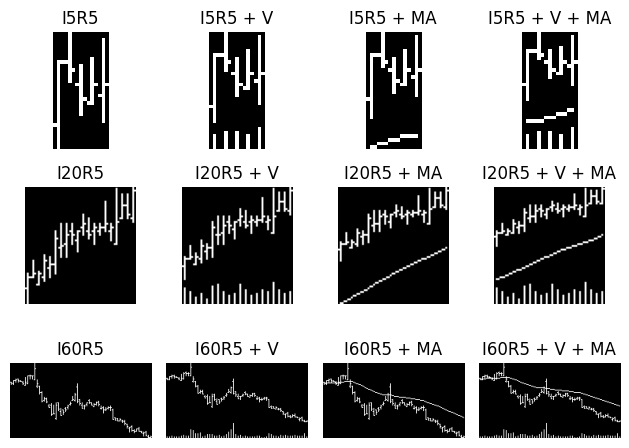

In [14]:
## Generate images for 5-days. The 20th entry was chosen arbitrarily.
I5R5_sample = draw_ohlc_graph(I5R5_data[20], 5, is_volume = False, is_moving_avg = False)
I5R5_sample_v = draw_ohlc_graph(I5R5_data[20], 5, is_volume = True, is_moving_avg = False)
I5R5_sample_ma = draw_ohlc_graph(I5R5_data[20], 5, is_volume = False, is_moving_avg = True)
I5R5_sample_v_ma = draw_ohlc_graph(I5R5_data[20], 5, is_volume = True, is_moving_avg = True)

## Generate images for 20-days. The 20th entry was chosen arbitrarily.
I20R5_sample = draw_ohlc_graph(I20R5_data[20], 20, is_volume = False, is_moving_avg = False)
I20R5_sample_v = draw_ohlc_graph(I20R5_data[20], 20, is_volume = True, is_moving_avg = False)
I20R5_sample_ma = draw_ohlc_graph(I20R5_data[20], 20, is_volume = False, is_moving_avg = True)
I20R5_sample_v_ma = draw_ohlc_graph(I20R5_data[20], 20, is_volume = True, is_moving_avg = True)

## Generate images for 60-days. The 20th entry was chosen arbitrarily.
I60R5_sample = draw_ohlc_graph(I60R5_data[20], 60, is_volume = False, is_moving_avg = False)
I60R5_sample_v = draw_ohlc_graph(I60R5_data[20], 60, is_volume = True, is_moving_avg = False)
I60R5_sample_ma = draw_ohlc_graph(I60R5_data[20], 60, is_volume = False, is_moving_avg = True)
I60R5_sample_v_ma = draw_ohlc_graph(I60R5_data[20], 60, is_volume = True, is_moving_avg = True)

## Create Figure and Axis.
fig, axs = plt.subplots(3, 4)

## Plot I5R5 images.
axs[0, 0].imshow(np.asarray(I5R5_sample), cmap = 'gray')
axs[0, 0].set_title('I5R5')
axs[0, 0].axis('off')

axs[0, 1].imshow(np.asarray(I5R5_sample_v), cmap = 'gray')
axs[0, 1].set_title('I5R5 + V')
axs[0, 1].axis('off')

axs[0, 2].imshow(np.asarray(I5R5_sample_ma), cmap = 'gray')
axs[0, 2].set_title('I5R5 + MA')
axs[0, 2].axis('off')

axs[0, 3].imshow(np.asarray(I5R5_sample_v_ma), cmap = 'gray')
axs[0, 3].set_title('I5R5 + V + MA')
axs[0, 3].axis('off')

## Plot I20R5 images.
axs[1, 0].imshow(np.asarray(I20R5_sample), cmap = 'gray')
axs[1, 0].set_title('I20R5')
axs[1, 0].axis('off')

axs[1, 1].imshow(np.asarray(I20R5_sample_v), cmap = 'gray')
axs[1, 1].set_title('I20R5 + V')
axs[1, 1].axis('off')

axs[1, 2].imshow(np.asarray(I20R5_sample_ma), cmap = 'gray')
axs[1, 2].set_title('I20R5 + MA')
axs[1, 2].axis('off')

axs[1, 3].imshow(np.asarray(I20R5_sample_v_ma), cmap = 'gray')
axs[1, 3].set_title('I20R5 + V + MA')
axs[1, 3].axis('off')

## Plot I60R5 images.
axs[2, 0].imshow(np.asarray(I60R5_sample), cmap = 'gray')
axs[2, 0].set_title('I60R5')
axs[2, 0].axis('off')

axs[2, 1].imshow(np.asarray(I60R5_sample_v), cmap = 'gray')
axs[2, 1].set_title('I60R5 + V')
axs[2, 1].axis('off')

axs[2, 2].imshow(np.asarray(I60R5_sample_ma), cmap = 'gray')
axs[2, 2].set_title('I60R5 + MA')
axs[2, 2].axis('off')

axs[2, 3].imshow(np.asarray(I60R5_sample_v_ma), cmap = 'gray')
axs[2, 3].set_title('I60R5 + V + MA')
axs[2, 3].axis('off')

## Plot all images.
plt.tight_layout()
plt.show()